In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
os.chdir('Data')

In [3]:
folders = {f.path[2:]: f.path for f in os.scandir() if f.is_dir()}
symbols = list(folders.keys())

In [4]:
def merge_tables(path):
    tables = list()
    for f in os.scandir(path):
        if f.is_file():
            tables.append(pd.read_csv(f))
    return pd.concat(tables, axis=0)

def load_symbol(symbol):
    symbol = symbol.lower()
    path = os.path.abspath(symbol)
    
    daily = merge_tables(os.path.join(path, f'{symbol}_daily'))
    intraday = merge_tables(os.path.join(path, f'{symbol}_intraday'))
    sentiment = merge_tables(os.path.join(path, f'{symbol}_sentiment'))
    
    return daily, intraday, sentiment

In [5]:
aapl_day, _, _ = load_symbol('aapl')

In [6]:
aapl_day.head()

,Time,Open,High,Low,Close,Volume
0,2020-02-04,315.3100,319.64,313.6345,318.85,33656524
1,2020-02-03,304.3000,313.49,302.2200,308.66,43496401
2,2020-01-31,320.9300,322.68,308.2900,309.51,49897096
3,2020-01-30,320.5435,324.09,318.7500,323.87,31685808
4,2020-01-29,324.4500,327.85,321.3800,324.34,54149928


In [7]:
aapl_close = pd.DataFrame(aapl_day.set_index('Time')[['Close']])

In [8]:
def sma(df, metric, n):
    return df[metric].rolling(window=n).mean().shift(-n)

def ema(df, metric, n):
    return df.iloc[::-1][metric].ewm(span=n, adjust=False).mean().iloc[::-1]

In [9]:
aapl_close['SMA_50'] = sma(aapl_close, 'Close', 50)
aapl_close['SMA_200'] = sma(aapl_close, 'Close', 200)

aapl_close['EMA_12'] = ema(aapl_close, 'Close', 12)
aapl_close['EMA_26'] = ema(aapl_close, 'Close', 26)
aapl_close['EMA_50'] = ema(aapl_close, 'Close', 50)
aapl_close['EMA_200'] = ema(aapl_close, 'Close', 200)

In [10]:
aapl_close.head()

,Close,SMA_50,SMA_200,EMA_12,EMA_26,EMA_50,EMA_200
Time,,,,,,,
2020-02-04,318.85,290.3734,232.084775,314.879257,307.859469,294.162216,245.184663
2020-02-03,308.66,289.5260,231.557125,314.157303,306.980227,293.154552,244.444307
2020-01-31,309.51,288.6778,231.005825,315.156813,306.845845,292.521676,243.798924
2020-01-30,323.87,287.5156,230.382625,316.183506,306.632712,291.828275,243.138511
2020-01-29,324.34,286.2816,229.755275,314.785962,305.253729,290.520450,242.327139


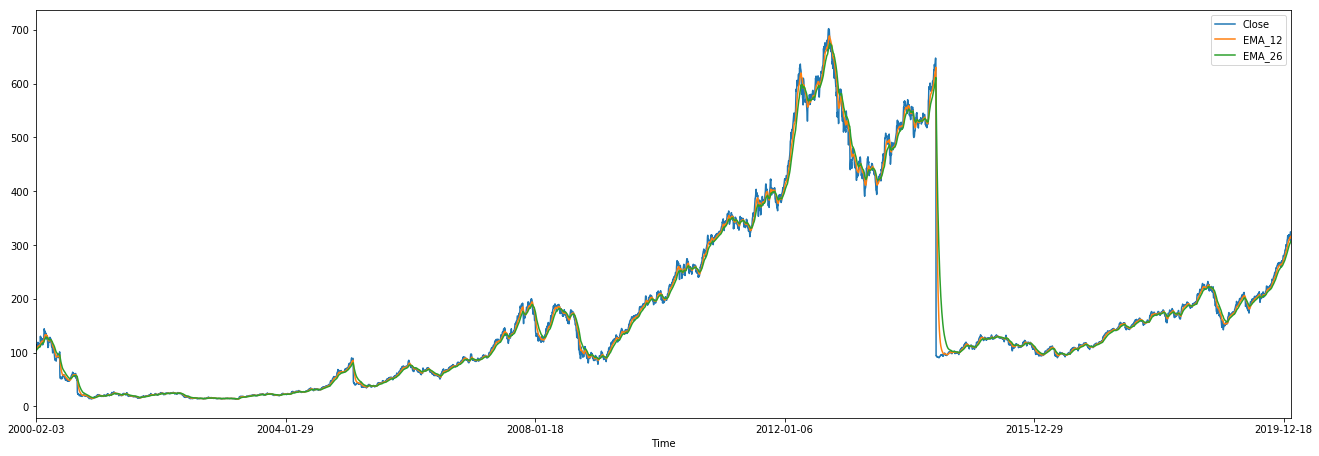

In [17]:
aapl_close.iloc[::-1][['Close', 'EMA_12', 'EMA_26']].plot(figsize=(22.5, 7.5))
plt.show()

In [63]:
def plot_intersect(x, background, f, g):
    plt.figure(figsize=(22.5, 7.5))
    
    plt.plot(x, background, '-')
    plt.plot(x, f, '-')
    plt.plot(x, g, '-')
    gi = np.nan_to_num(g, 0)
    idx = np.argwhere(np.diff(np.sign(f - gi))).flatten()
    plt.plot(x[idx], f[idx], 'ro')
    
#     plt.autofmt_xdate()
    plt.plot()

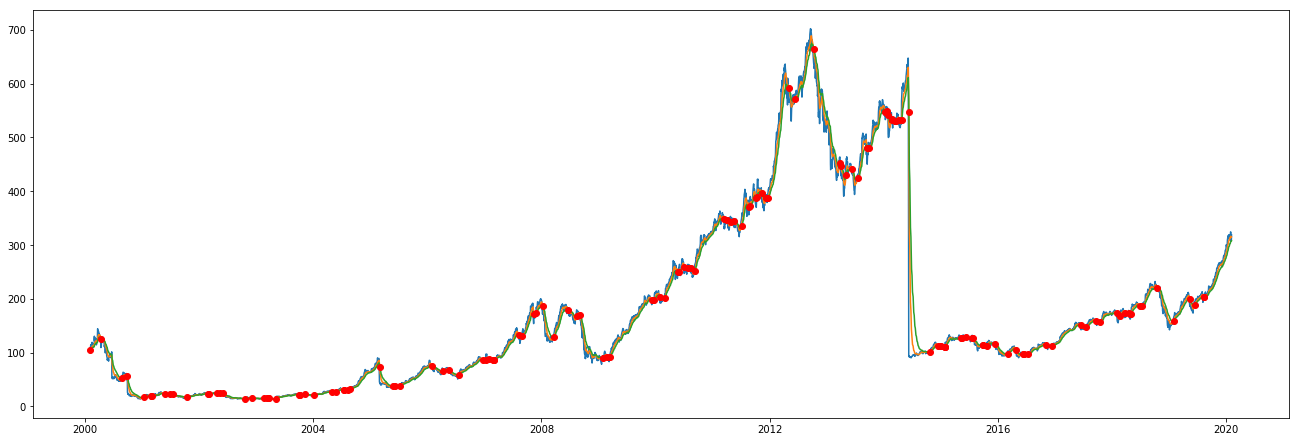

In [66]:
plot_intersect(np.array(pd.to_datetime(aapl_close.index)), aapl_close['Close'], aapl_close['EMA_12'], aapl_close['EMA_26'])